# PCA Report of Arrests made within the US

This dataset is from the US Arrests Kaggle challenge (https://www.kaggle.com/datasets/kurohana/usarrets). 

A description of the data is given as: “This data set contains statistics, in arrests per 100,000 residents,
for assault, murder, and rape in each of the 50 US states in 1973. Also given is the
percent of the population living in urban areas.”

In [20]:
# Load required Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize

from sklearn.decomposition import PCA
from pca import pca

from sklearn.metrics import accuracy_score, silhouette_score

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as shc

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

# Ignoring OMP thread count with k-means
import warnings
warnings.filterwarnings('ignore') 

## Data Exploration

In [35]:
# Load in the data

df = pd.read_csv('UsArrests.csv')
df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [3]:
# Understanding the DataFrame

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


What we find here with our DataFrame, is that we have 5 features. The data is described as containing statistics of the number of arrests made per 100 000 residents for 3 types of crimes (Murder, assualt and rape) within each 50 states.

The objective of our report, will be to use PCA and hierarchical clustering to represent how each crime attributes itself to each state. We can therefore impose segragation on our data as city being the response variable, while crime and population are our predictor variables.

This allows us to then convert all predictor variables to the same datatype purely for convenience sake.

In [4]:
# Make numerical features all float types

df["Assault"] = df["Assault"].astype("float64")
df["UrbanPop"] = df["UrbanPop"].astype("float64")
df.dtypes

City         object
Murder      float64
Assault     float64
UrbanPop    float64
Rape        float64
dtype: object

In [5]:
# Checking for any missing values within the data set

print('Calculating any Missing values contained in the DateFrame:\n',df.isnull().sum())

Calculating any Missing values contained in the DateFrame:
 City        0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64


In [6]:
# Performing a Statistical summary of our dataset

df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


When performing a PCA report, one must always keep in mind how each feature correlates with one another. This is important as it gives insight as to how dimensionality reduction works.

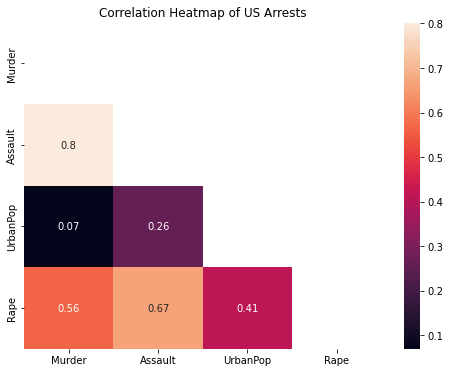

In [7]:
# Looking at how our Datas' features correlate with one another

plt.figure(figsize=(8,6))
Arrest_corr = df.corr()

# to mask mirrored side of heatmap
dropmirror = np.zeros_like(Arrest_corr)
dropmirror[np.triu_indices_from(dropmirror)] = True

sns.heatmap(Arrest_corr, annot=True, mask=dropmirror)
plt.title('Correlation Heatmap of US Arrests')
plt.show()

Understanding the distribution of our data is a vital aspect to producing accurate reports. We know, based of the descriptive statitiscal analysis done, that our data contains certain features that have either a large or small range of values. The features are also quite difficult to make comparisons as Urbanpop is a percentage value representing population of residents within each state, while number of murders, rapes and assualt are all distinct numeric values that are not denoted as percentages.

We can further investigate this assumption by plotting how each feature has been distributed. 

I will use a boxplot to represent the distribution.

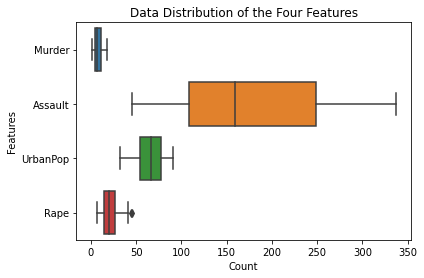

In [8]:
# Creating a boxplot for feature distributions

sns.boxplot(data=df, orient='h')
plt.ylabel('Features')
plt.xlabel('Count')
plt.title('Data Distribution of the Four Features')
plt.show()

## Data Scaling

In order to get a accurate analysis of our data, we need to ensure that each feature is found within the same range of values. We therefore need to scale our data appropriately

In [9]:
# select independent and standardize features

scaled = StandardScaler().fit_transform(df.iloc[:,1:5])

# created scaled version of DataFrame

df_scale = pd.DataFrame(scaled, columns = df.columns[1:5])
df_scale.head()

,Murder,Assault,UrbanPop,Rape
0,1.255179,0.790787,-0.526195,-0.003451
1,0.513019,1.118060,-1.224067,2.509424
2,0.072361,1.493817,1.009122,1.053466
3,0.234708,0.233212,-1.084492,-0.186794
4,0.281093,1.275635,1.776781,2.088814


## Selecting Number of Components for PCA

PCA allows us to select components within our Dataset to describe what is actually happening. A standard form dataframe contains all features, whereas PCA selects principle components that attribute the greatest factor in determining a desired outcome. 

Typically, we look for a variance factor between 80% and 99% for our components. The absolute minimum threshold for variance should not be below 60%. This opens up to biased and unreliable data. We are able to easily identify the minimum number of components needed to reach this threshold by utilizing scikit-learn. 

In [10]:
# Showing how each component attributes itself to the explained variance

pca = PCA().fit(df_scale)

pca.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

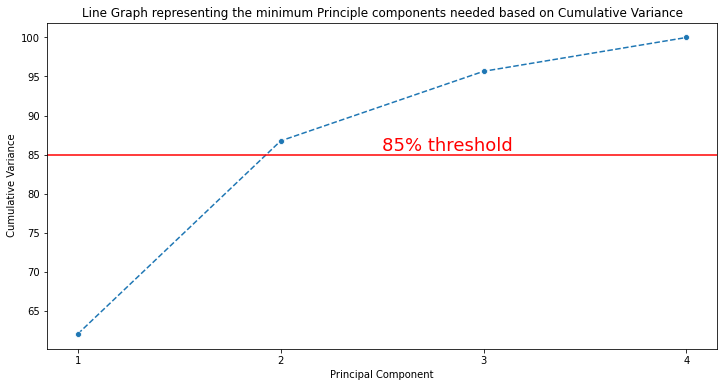

In [11]:
# Creating a graph to show the minimum number of components needed for our analysis

X = np.arange(1, 5, step=1)

plt.figure(figsize=(12,6))
sns.lineplot(x=X, y = np.cumsum(pca.explained_variance_ratio_)*100, linestyle='--', marker='o' )

plt.title('Line Graph representing the minimum Principle components needed based on Cumulative Variance')
plt.xlabel('Principal Component')
plt.xticks(np.arange(1, 5, step=1))
plt.ylabel(' Cumulative Variance')
plt.axhline(y=85, color='r', linestyle='-')
plt.text(2.5, 85.5, '85% threshold', color = 'red', fontsize=18)
plt.show()

What the above graph tells us, is that component 1 contains 62% of all explained variances within our data. Component 2 contains 24.74% of all explained variances. Adding all this up, we find that with 2 Principle components, we achieve a explanation of variance within our data of 86.74%. What this means. is that we effectively got rid of 50% of our data, yet are still able to maintain a 86.74% explanation value as to how our features deviate or affects one another.  

We can then proceed with our analysis and work with 2 components.

In [12]:
# Proceeding with 2 components

pca = PCA(n_components = 2)

PC = pca.fit_transform(df_scale)

PC.shape

(50, 2)

In [13]:
# transform the components into a pandas data frame

PC_df = pd.DataFrame(data = PC, columns = ['Principal Component 1','Principal Component 2'])

PC_df['City'] = df['City']

PC_df.head()

,Principal Component 1,Principal Component 2,City
0,0.985566,1.133392,Alabama
1,1.950138,1.073213,Alaska
2,1.763164,-0.745957,Arizona
3,-0.141420,1.119797,Arkansas
4,2.523980,-1.542934,California


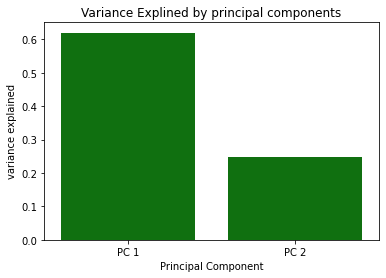

In [14]:
# Creating a barplot to visually represent how each Component affects the variance

df = pd.DataFrame({'variance explained': pca.explained_variance_ratio_, 'Principal Component': ['PC 1', 'PC 2']})

plt.title('Variance Explined by principal components')
sns.barplot(x='Principal Component', y='variance explained', data=df, color='g')
plt.show()

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
[pca] >Plot PC1 vs PC2 with loadings.


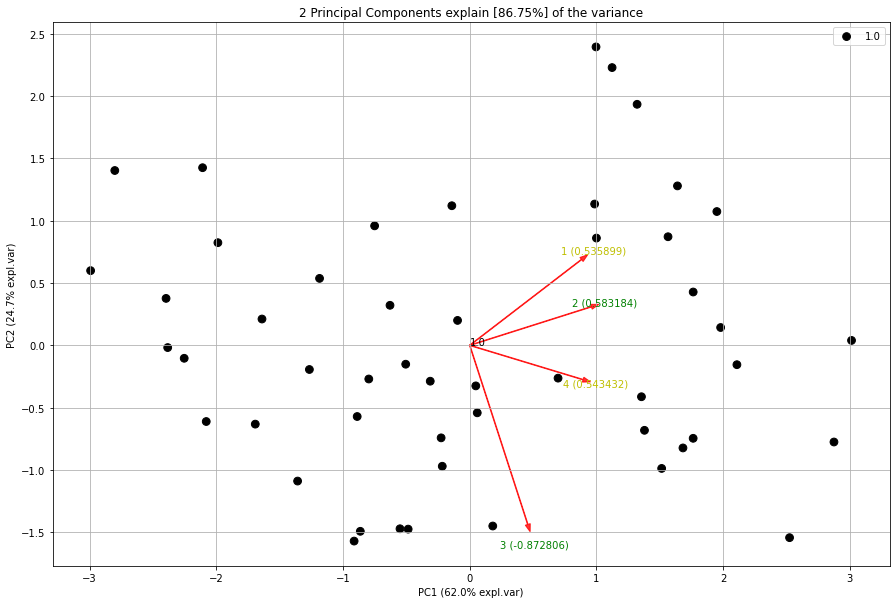

In [17]:
# Create a biplot to represent Components within the total DataFrame

model = pca(n_components=2)

results = model.fit_transform(scaled)

# Make biplot with the total number of features

fig, ax = model.biplot(n_feat=4, )

The above shows the observations as points in the plane formed by two principal components. Samples are displayed as points, in our case, the different cities are all points on the biplot. while, Vectors indicate the different variables. Our data contained 4 variables, being Murder, Assualt, Rape and Urban-population. All 4 variables are shown on the above graph. 

Each Variable shown has had a positive correlation with the first Principle Component. The feature component, 'UrbanPop' denoted here by '3', has the relatively highest correlation with the 2nd principle component. Additionally, it is the only correlation which is negative.

## Cluster Analysis

We will perform both Hierarchical Clustering and K-means with these data and
compare the results

### K-Means Analysis

K-means finds observations that share important characteristics and classifies them together into clusters. In order for K-means to achieve optimum accuracy, we need to determine the number of clusters needed for our data. We can do this by implementing whats called the K-means elbow method. The elbow method runs k-means clustering on the dataset for a range of values for k (say from 1-10) and then for each value of k computes an average score for all clusters.

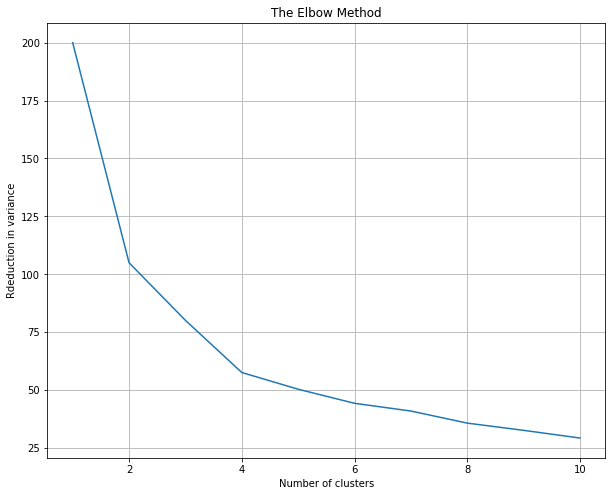

In [18]:
plt.figure(figsize=(10, 8))
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(scaled)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Rdeduction in variance')
plt.grid()

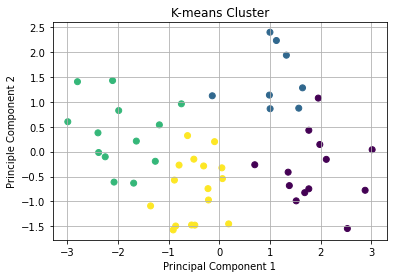

In [51]:
# fitting k-means to the dataset

kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 1 )
ykmeans = kmeans.fit_predict(scaled)

plt.scatter(x=PC_df['Principal Component 1'], y=PC_df['Principal Component 2'], c = ykmeans)
plt.title('K-means Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principle Component 2')
plt.grid()
plt.show()

Each dot from the above graph represents a city. Each city has been grouped into 1 of 4 colours. Each colour represents a different Feature of the orginal dataset that attributes most to that city.

In [65]:
# Calculate the Silhouette scpre of the cluster model

print('Silhouette Score for the K-means model')

print(silhouette_score(scaled, ykmeans))

Silhouette Score for the K-means model
0.3396889143334439


### Agglomerative Clustering

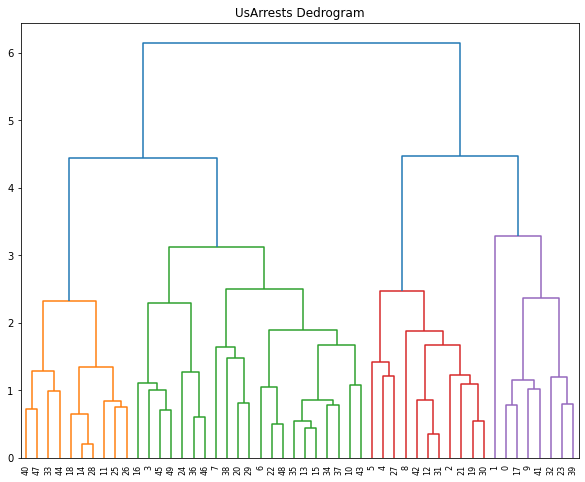

In [58]:
plt.figure(figsize = (10, 8))
plt.title('UsArrests Dedrogram')
dend = shc.dendrogram(shc.linkage(scaled, method = 'complete'))

In [59]:
cluster = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'complete')

cluster.fit_predict(scaled)

array([0, 0, 2, 1, 2, 2, 1, 1, 2, 0, 1, 3, 2, 1, 3, 1, 1, 0, 3, 2, 1, 2,
       1, 0, 1, 3, 3, 2, 3, 1, 2, 2, 0, 3, 1, 1, 1, 1, 1, 0, 3, 0, 2, 1,
       3, 1, 1, 3, 1, 1], dtype=int64)

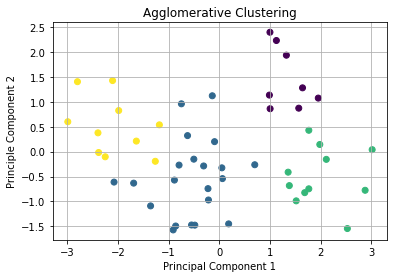

In [62]:
plt.scatter(x=PC_df['Principal Component 1'], y=PC_df['Principal Component 2'], c = cluster.labels_)
plt.title('Agglomerative Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principle Component 2')
plt.grid()
plt.show()

In [67]:
print('Silhouette Score for the Agglomerative Cluster')

print(silhouette_score(scaled, cluster.fit_predict(scaled)))

Silhouette Score for the Agglomerative Cluster
0.31595507426164543


### Performing Sensitivity Analysis of Each Cluster model

#### Sensitivity Anlysis of K-Means Model

Cluster:  2 
Score:  0.408


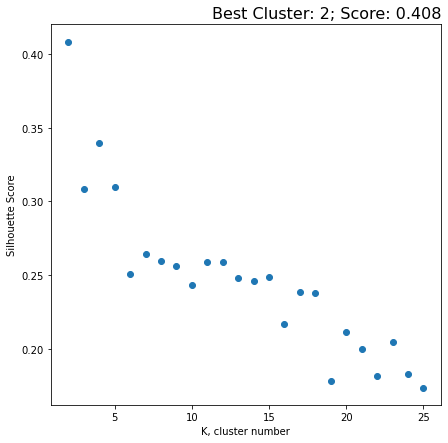

In [77]:
# Create a function that tests the best Cluster size as well as the silhouette score of each model
def sens_analysis(K_min, K_max, X):
    score ={}
    for K in range(K_min, K_max +1):
        model = KMeans(n_clusters = K, init = 'k-means++', random_state = 123)
        y_preds = model.fit_predict(X)
        
        score[K] = silhouette_score(X, model.labels_, metric = 'euclidean')
    
#Finding max silhouette score
    for key, value in score.items():
         if score[key] == max(score.values()):
             print("Cluster: ", key, "\nScore: ", round(value,3))
             a = f"Best Cluster: {key}; Score: {round(value,3)}"
        
    
#prints scatter plot
    plt.subplots(1, 1, figsize = (7, 7))
    plt.scatter(x = list(score.keys()), y = list(score.values()))
    plt.title(a, loc='right', fontdict={'fontsize': 16})
    plt.xlabel('K, cluster number')
    plt.ylabel('Silhouette Score')

sens_analysis(2, 25, scaled)

#### Sensitivity Anlysis of Agglomerative Model

In [73]:
# Create a function that tests the best Cluster size as well as the silhouette score of each model

def sens_analysis(K_min, K_max, X, link):
    score ={}
    for K in range(K_min, K_max +1):
        
        model = AgglomerativeClustering(n_clusters = K, affinity = 'euclidean', linkage = link)
        y_preds = model.fit_predict(X)     
        
        score[K] = silhouette_score(X, model.labels_)
    
# Finding max silhouette score which is used as title   
    for key, value in score.items():
         if score[key] == max(score.values()):
            title = f"Best Cluster: {key}; Score: {round(value,2)}"
    
# prints scatter plot
    plt.subplots(1, 1, figsize = (7, 7))
    plt.scatter(x = list(score.keys()), y = list(score.values()))
    plt.title(title+"; Linkage: "+link, loc='right', fontdict={'fontsize': 16})
    plt.xlabel('K, cluster number')
    plt.ylabel('Silhouette Score')

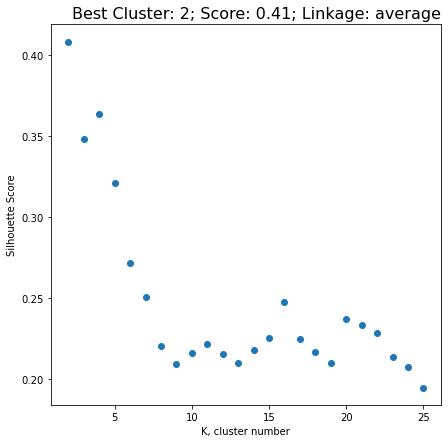

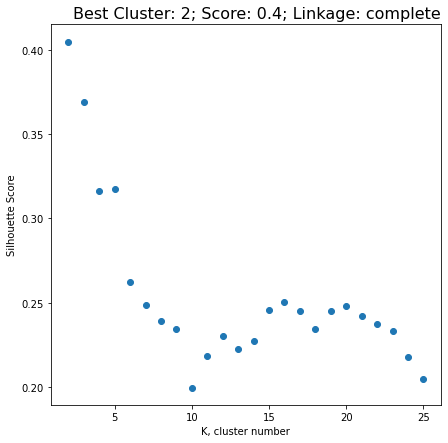

In [76]:
 #displays both graphs
for method in ('average','complete'):
    sens_analysis(2, 25, scaled, method)

## Summary

For this task we had to investigate US Arrests made in the year 1973 per 100 000 people within each of the 50 states. 

This was done by employing unsupervised learning models such as Principle Component Analysis as well as K-means Clustering and Agglomerative Clustering models.

PCA resulted in our data set, which originally contained 4 features, to be reduced to 2 main principle components. These components were shown to attribute over 85% of the total degree of explanation of how each individual response variable fluctuates.

For the Clustering Anlysis, I had initially chosen to set K = 4. I had done this on the basis that we had 4 features. However, on producing my sensitivity anlysis, we find that the best clusters for both models should actually be 2. This analysis is done on a silhouette score and the ability for the model to make better grouping predictions. I do not believe, though, that we should pay particular attention to this cluster segregation, as the model merely shows how well it can group variables based on the number of clusters. We do in fact have 4 features that require 4 different groupings. 

What I did find interesting is that when using 4 clusters, the K-means model achieves a higher silhouette score than the agglomerative model, yet when we use only 2 clusters, the Agglomerative model achieves a higher silhouette score. 

## References

https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c
https://www.reneshbedre.com/blog/principal-component-analysis.html
https://stats.stackexchange.com/questions/311908/what-is-pca-components-in-sk-learn
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html